**The goal of this notebook is to work on the string matching so that we can more accurately choose all of the stores. The problem with the current string matching is that it excudes other things that should be matched**






In [4]:
import pandas as pd
import numpy as np 
import geopandas as gpd
import matplotlib 
from matplotlib import pyplot as plt 
pd.set_option('display.max_columns',None)
import seaborn as sns 
from shapely.geometry import Point, Polygon 


dataset = pd.read_csv('/srv/data/my_shared_data_folder/rafi/2022_Business_Academic_QCQ_grocery.csv')
dataset.drop(['Unnamed: 0'],inplace=True,axis=1)
dataset

pure = pd.read_csv('/srv/data/my_shared_data_folder/rafi/2022_Business_Academic_QCQ_grocery.csv')
pure.drop(['Unnamed: 0'],inplace=True,axis=1)



In [5]:
pure = pd.read_csv('/srv/data/my_shared_data_folder/rafi/2022_Business_Academic_QCQ_grocery.csv')
pure.drop(['Unnamed: 0'],inplace=True,axis=1)

In [6]:
dataset.loc[dataset["PRIMARY NAICS CODE"] == 445110]

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE


In [7]:
stores_2022 = pd.read_csv('/srv/data/my_shared_data_folder/rafi/2022_Business_Academic_QCQ_grocery.csv')
stores_2022.drop(['Unnamed: 0'],inplace=True,axis=1)
territories = ['PR', 'FM', 'MP', 'GU', 'VI', 'MH']
stores_2022 = stores_2022.drop(stores_2022[stores_2022['STATE'].isin(territories)].index)
stores_2022.head(10)

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE
0,GOMART,55 POSTAL PLZ,MORGANTOWN,WV,26508,7005.0,61.0,304,2,C,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,554110.0,ALTERNATIVE FUELS,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,13.0,2482.0,2,NaN,NaN,NaN,NaN,998372387,NaN,124929449.0,50.0,389500.0,E,I,998372387.0,NaN,7,11000.0,3.0,39.594376,-79.954437,P,34060.0,2.0,390.0,54061.0
1,7-ELEVEN,485 E MAIN ST,EL CENTRO,CA,92243,2619.0,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,W,NaN,NaN,NaN,495660326,NaN,5863311.0,800.0,1272634.0,H,K,495660326.0,NaN,7,11400.0,3.0,32.792679,-115.536058,0,20940.0,2.0,0.0,6025.0
2,EL SOL MARKET,110 W MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,5.0,1061.0,9,NaN,NaN,NaN,NaN,519605455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0
3,COOL SPRINGS GROCERY,241 WILDWOOD ST,MORGANTOWN,WV,26505,3141.0,61.0,304,2,A,A,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,2.0,382.0,9,NaN,NaN,NaN,NaN,817953730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,10400.0,4.0,39.652885,-79.986398,P,34060.0,2.0,390.0,54061.0
4,CIRCLE K,123 E MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,F,NaN,NaN,NaN,855113817,NaN,450720289.0,650.0,4981020.0,H,J,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0
5,EL SOL MEAT MARKET,1100 MEADOWS RD # B,CALEXICO,CA,92231,5917.0,25.0,760,2,D,E,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,542107.0,MEAT-RETAIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,29.0,6153.0,9,NaN,NaN,NaN,NaN,995912391,NaN,NaN,NaN,NaN,NaN,NaN,995912391.0,NaN,7,12002.0,2.0,32.679923,-115.482166,P,20940.0,2.0,0.0,6025.0
6,AMPM,73434 29 PALMS HWY,TWENTYNINE PALMS,CA,92277,3129.0,71.0,760,2,C,D,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,554110.0,ALTERNATIVE FUELS,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,10.0,2631.0,2,A,2004.0,NaN,NaN,547898643,425040557.0,1490291.0,5000.0,7616641.0,J,K,547898643.0,NaN,7,10421.0,1.0,34.135287,-116.059794,P,40140.0,2.0,348.0,6071.0
7,KROGER,1600 S OHIO ST,MARTINSVILLE,IN,46151,3317.0,109.0,765,2,F,G,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,102.0,21931.0,2,P,NaN,NaN,NaN,140765967,NaN,7521503.0,1200.0,137888000.0,I,I,140765967.0,NaN,7,510701.0,2.0,39.411880,-86.425148,P,26900.0,2.0,294.0,18109.0
8,FOOD 4 LESS,2420 COTTONWOOD DR,EL CENTRO,CA,92243,1604.0,25.0,760,2,E,F,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,70.0,14851.0,2,ï¿½,NaN,NaN,NaN,2

In [8]:
#Filter Grocery stores by sic (starting with 541105 & 531102)
grocery_sic = stores_2022.loc[stores_2022[['PRIMARY SIC CODE']].astype(str).apply(lambda x: x.str.startswith('541105')).any(axis=1)]
grocery_sic.head(10)

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE
2,EL SOL MARKET,110 W MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,5.0,1061.0,9,NaN,NaN,NaN,NaN,519605455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0
3,COOL SPRINGS GROCERY,241 WILDWOOD ST,MORGANTOWN,WV,26505,3141.0,61.0,304,2,A,A,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,2.0,382.0,9,NaN,NaN,NaN,NaN,817953730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,10400.0,4.0,39.652885,-79.986398,P,34060.0,2.0,390.0,54061.0
5,EL SOL MEAT MARKET,1100 MEADOWS RD # B,CALEXICO,CA,92231,5917.0,25.0,760,2,D,E,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,542107.0,MEAT-RETAIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,29.0,6153.0,9,NaN,NaN,NaN,NaN,995912391,NaN,NaN,NaN,NaN,NaN,NaN,995912391.0,NaN,7,12002.0,2.0,32.679923,-115.482166,P,20940.0,2.0,0.0,6025.0
7,KROGER,1600 S OHIO ST,MARTINSVILLE,IN,46151,3317.0,109.0,765,2,F,G,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,102.0,21931.0,2,P,NaN,NaN,NaN,140765967,NaN,7521503.0,1200.0,137888000.0,I,I,140765967.0,NaN,7,510701.0,2.0,39.411880,-86.425148,P,26900.0,2.0,294.0,18109.0
8,FOOD 4 LESS,2420 COTTONWOOD DR,EL CENTRO,CA,92243,1604.0,25.0,760,2,E,F,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,70.0,14851.0,2,ï¿½,NaN,NaN,NaN,215261702,402627138.0,7521503.0,1200.0,137888000.0,I,I,215261702.0,NaN,7,11201.0,1.0,32.815719,-115.572166,P,20940.0,2.0,0.0,6025.0
13,KROGER,301 E MCKINLEY RD,OTTAWA,IL,61350,4805.0,99.0,815,2,E,F,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,70.0,14158.0,2,P,NaN,NaN,NaN,152123287,NaN,7521503.0,1200.0,137888000.0,I,I,152123287.0,NaN,7,963500.0,1.0,41.323858,-88.836271,P,36837.0,1.0,176.0,17099.0
14,WOODS SUPERMARKET,1407 W AUSTIN BLVD,NEVADA,MO,64772,2805.0,217.0,417,2,E,E,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,542107.0,MEAT-RETAIL,546102.0,BAKERS-RETAIL,591205.0,PHARMACIES,592102.0,LIQUORS-RETAIL,NaN,NaN,2022,39106.0,63.0,9332.0,2,NaN,NaN,NaN,NaN,452808512,NaN,834898306.0,20.0,48500.0,D,G,452808512.0,NaN,6,950300.0,5.0,37.836468,-94.374786,P,0.0,NaN,0.0,29217.0
16,SKY MARKET,1904 E PALOMAR ST # 108,CHULA VISTA,CA,91913,5043.0,73.0,619,2,A,B,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,539901.0,GENERAL MERCHANDISE-RETAIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,3.0,543.0,9,NaN,2017.0,NaN,NaN,724918224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,13313.0,1.0,32.626419,-116.975922,P,41740.0,2.0,0.0,6073.0
23,STATER BROS MARKETS,78630 HIGHWAY 111 # A,LA QUINTA,CA,92253,2049.0,65.0,760,2,F,G,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
pd.set_option('display.max_columns', None)
from shapely.geometry import Point
import fiona
import math
import plotly.express as px
from thefuzz import fuzz
from thefuzz import process

/opt/tljh/user/lib/python3.9/site-packages/thefuzz/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [10]:
#Create lists of Supermarkets/Companies owned by the Parent Coporations of Interest (Supermarkets/Companies were taken from Wikipedia)

#Ahold Delhaize owned supermarkets/companies
ahold = ["Bottom Dollar Food",
    "Food Lion",
    "FreshDirect",
    "Giant",
    "Giant Food",
    "Hannaford",
    "Stop & Shop",
    "Peapod",
    "Bfresh",
    "Eastside Marketplace",]

#WALMART owned supermarkets/companies
walmart = ["WALMART","SAM'S CLUB"]

#Krogers owned supermarkets/companies
kroger = ["Baker's",
    "City Market",
    "Dillons",
    "Food 4 Less",
    "Foods Co.",
    "Fred Meyer",
    "Fry's",
    "Gerbes",
    "Harris Teeter",
    "JayC",
    "King Soopers",
    "Kroger",
    "Mariano's",
    "Metro Market",
    "Pay Less",
    "Pick 'n Save",
    "QFC",
    "Ralphs",
    "Ruler Foods",
    "Smith's",]

# Albertsons owned supermarkets/companies
albertsons= ["Acme Markets",
    "Albertsons",
    "Albertsons Market",
    "Amigos",
    "Andronico's",
    "Balducci's",
    "Carrs",
    "Haggen",
    "Jewel-Osco",
    "Kings Food Markets",
    "Lucky",
    "Market Street",
    "Pak 'n Save",
    "Pavilions",
    "Randalls",
    "Safewa",
    "Shaw's",
    "Star Market",
    "Tom Thumb",
    "United Supermarkets",
    "Vons",
    "Buttrey Food and Drug",
    "Max Food and Drug",
    "Max Foods",
    "Skagg's Albertsons",
    "Super Saver",]

#Costco owned supermarkets/companies
costco = ["Costco"]

In [11]:
#Generated String Matches from above

#String matched brands owned by Walmart:
walmart_string = ['WALMART GROCERY PICKUP', 'WALMART GROCERY PKUP-DELIVERY', "SAM'S CLUB DELI"]

#String matched brands owned by Ahold Delhaize:
ahold_string = ['BOTTOM DOLLAR', 'DOLLAR DOLLAR', 'FOOD', 'FOOD 4 LESS', 'FOOD LION', 'FRESH DIRECT', 'REC', 'FRESH', 'H & H', 'S & S', 'FRESHII', 'GIANT', 'GIANT EAGLE', 'GIANT EAGLE FLORAL', 'GIANT FOOD', 'HANNAFORD', 'STOP & SHOP', 'PEA POD', 'BFRESH MARKET', 'REFRESH', 'EASTSIDE MARKETPLACE', 'WESTSIDE MARKETPLACE', 'MARKET', 'E MARKET', 'MARKETPLACE']

#String matched brands owned by Kroger:
kroger_string = ["BAKER'S", 'S & S', 'BAKERS', "BAKER'S GAS & WELD SUPLS INC", "BAKER'S GAS", "BAKER'S MARKET", "BAKER'S PRO FARM LLC", 'BAKER STREET MARKET', "BAKER'S KWIK SHOP", 'CITY MARKET', 'DILLONS', 'FOOD 4 LESS', 'FOODS CO', 'FRED MEYER', "FRY'S FOOD", 'GERBES SUPER MARKET', 'GERBES SUPER MARKETS', 'GE', 'GERBES SUPERMARKET', 'HARRIS TEETER', 'JAYC', "JAYCEE'S", 'JAYCON', 'CITY-RALEIGH-JAYCEE PARK-CMNTY', 'JAYCE MINIMARKET', 'NAY & JAY', 'KING SOOPERS', 'KROGER', "MARIANO'S", 'METRO MARKET', 'METRO MINI MARKET', 'MARKET MARKET', 'PAY LESS LIQUORS', 'PAY LESS SUPER MARKETS', 'PAY LESS GAS & FOOD', 'PAY LESS IGA', 'FOOD FOR LESS', 'FAR LESS FOOD MARKET', 'MORE FOR LESS', 'PRICE LESS FOODS', 'COST LESS FOODS CO', "PICK'N SAVE", 'QFC', 'RALPHS', 'RULER FOODS', "SMITH'S"]

#String matched brands owned by Costco
costco_string = ["COSTCO DELI"]

#String matched brands owned by Albertsons
albertsons_string = ['ACME MARKETS', 'ALBERTSONS', 'ALBERTSONS MARKET', 'MARKET MARKET', 'MARKET', '2 AMIGOS', 'AMIGO', 'LOS AMIGOS DISTRIBUTING', 'DOS AMIGOS MARKET', '3 AMIGOS BEER WINE-FOOD STORE', 'THREE AMIGOS', 'AMIGOS FOOD MART', 'LOS AMIGOS', 'AMIGOS MKT LOS', 'AMIGOS MARKET 7', 'TIENDA LOS AMIGOS', 'AMIGOS CONVENIENCE STORE', 'LOS AMIGOS UNO', 'AMIGOS LATIN GROCERY', 'AMIGOS UNITED', 'AMIGOS FOOD MART LLC', 'LOS AMIGOS MARKET', 'LOS AMIGOS SUPERMARKET', 'ICO', "ANDRONICO'S COMMUNITY MARKETS", "KRAUSZER'S FOOD STORE", "CASEY'S", "MR T'S", "SEVEN'S", "PATTY'S PANTRY & DELI", "CASHION'S QUIK STOP", 'E C F S SNACKS LLC', "MICKEY'S T-MART INC", "STATLER'S COUNTRY MART", "MIKE'S CONVENIENCE", "BELL'S ROWLESBURG GROCERY", "SOCCORSI'S GROCERY & SUBS", 'CC', "BALDUCCI'S FOOD LOVER'S MARKET", "DANIEL'S MARKET", "GRILLO'S MARKET", 'S & G CONVENIENCE MART', "NANCY'S FOODMART", "MILLER'S MARKETS", "MAYNARD'S OF FLANDREAU", "SKIP'S", "HARDESTY'S EXPRESS MART LLC", "KASSAR'S FOOD & GIFTS", "JERRY'S MARKET & LIQUOR", "SHELLY'S GROCERY & BAKERY LLC", 'CARRS/SAFEWAY', 'CARRS SAFEWAY', 'CARRS QUALITY CTR PALMER SHPG', 'BIG CHEAP CASH & CARR', 'C & B USED CARS', 'HAGGEN', 'HAGGEN FOOD & PHARMACY', 'HAGGEN SUPPORT CTR', 'HAGGEN FOOD', 'GE', 'JEWEL-OSCO', 'KINGS FOOD MARKETS', 'KINGS FOOD MARKET', "KING'S FOOD MARKET", "KING'S FOODMARKET", 'KINGS FOOD MART', 'FOOD', 'LUCKY', 'LUCKY 3', 'LUCKY 7', "LUCKY'S", 'LUCKY 8', 'LUCKYS', 'LUCKY SEVEN FOOD STORE', 'LUCKY FOOD FARMERS MARKET', 'LUCKY GROCERY & DELI', 'LUCKY DOLLAR', 'LUCKY CHARM CONVENIENCE STORE', 'LUCKY STAR MARKET LLC', 'LUCKY FOOD MART LLC', 'LUCKY MARKET', "LUCKY'S STATION", 'LUCKY MARKET LLC', "LUCKY'S SUPER MARKET", 'MARKET STREET', "PAK 'N SAVE", 'U-SAVE FOOD STORE', 'GOLD LINE GRAB N GO', 'INDO PAK SUPERMARKET', 'STOP N GO FOOD MART', 'STOP N GO ENTERPRISES INC', "OCALA SHOP N' PLAY LLC", 'J & N MINI MART 2', "GRAB 'N GO MART LLC", 'KWIK PAK FOOD MART', "SHOP 'N SAVE EXPRESS", 'PIC-N-SAVE MARKET', 'U-SAVE TRAVEL PLAZA', "UP NORT' SWEET N SAVORY", 'STOP N SHOP WESTFIELD', "SACK 'N SAVE FOOD", "STOP 'N GO MARKETS OF TEXAS", 'CARTA N SHORE GARAGE', 'MASALA INDO PAK GROCERS', 'IN N OUT FOOD & GAS LLC', "GAS 'N' GO FOOD & BEVERAGE", 'N A M C COMMUNITY MARKET INC', 'PAVILIONS', 'RANDALLS', 'SAFEWAY', 'S & S', "SHAW'S SUPERMARKET", "SHAW'S SUPERMARKETS INC", 'STAR MARKET', 'TOM THUMB', 'UNITED SUPERMARKETS', 'VONS', 'FOOD 4 LESS', 'FOOD MART', 'FOOD LION', 'HERA FOOD MART', 'FOOD TOWN', 'FOOD FAIR', 'OHM FOOD MART', "D'S FOOD STORE", 'FOOD EXPRESS', 'E Z FOOD MART', 'JR FOOD MART', 'EXPRESS FOOD', 'MR FOOD MART', 'CITGO CONVENIENT FOOD MART', 'GREEN ACRES HEALTH FOOD STORE', 'FRIENDSHIP FOOD STORES INC', 'VERISTAS AFRICAN FOOD STORE', 'ILLINOIS VALLEY FOOD & DELI', "FRY'S FOOD", 'FOOD CITY', 'MAX FOODS', 'MAXI FOODS', 'FOODS', 'FOOD MAX', 'SUPER ONE FOODS', 'SUNSHINE FOODS', 'JAMBOREE FOODS', 'DAY STAR FOODS', "SULLIVAN'S FOODS", 'AFFILIATED FOODS CO-OP', "JENSEN'S FINEST FOODS", 'EAST DAKOTAH NATURAL FOODS', "JENSEN'S FOODS", 'RITE PRICE FOODS', 'VALLEY CENTER FOODS', 'SUPER SAVER', 'SUPER SAVE', 'SUPER SAVER INC', 'SUPER', 'SUPER SAVER COST PLUS', "SAAR'S SUPER SAVER FOODS"]

In [12]:
#Cleaned lists from the string matches of supermarkets/companies actually owned by the parent coprporation
#***NOTE***There will be a margin of error from this process because stores were validated through manual checks
#***NOTE***It was unrealistic to manually inspect every store generated this way so there will be supermarkets/companies that do not actually belong to the parent coporation

#KROGERS FINAL
kroger_clean = ["BAKER'S",
 'BAKERS', 
 'CITY MARKET',
 'DILLONS',
 'FOOD 4 LESS', 
 'FOODS CO', 
 'FRED MEYER', 
 "FRY'S FOOD",
 'GERBES SUPER MARKET',  
 'GERBES SUPER MARKETS', 
 'GERBES SUPERMARKET', 
 'HARRIS TEETER', 
 'JAYC', 
 'KING SOOPERS',
 'KROGER',
 "MARIANO'S",
 'METRO MARKET', 
 'PAY LESS SUPER MARKETS',
 "PICK'N SAVE", 
 'QFC', 
 'RALPHS', 
 'RULER FOODS', 
 "SMITH'S"]

#Ahold Delhaize FINAL:
ahold_clean = ['BOTTOM DOLLAR',
 'FOOD LION',
 'GIANT',
 'GIANT EAGLE',
 'GIANT FOOD',
 'HANNAFORD',
 'STOP & SHOP',
 'PEA POD',
 'BFRESH MARKET',
 'EASTSIDE MARKETPLACE']

#WALMART FINAL:
walmart_clean = ['WALMART GROCERY PICKUP',
 'WALMART GROCERY PKUP-DELIVERY', 
 "SAM'S CLUB DELI"]

#COSTCO FINAL:
costco_clean = ["COSTCO DELI"]

#ALBERTSONS FINAL:
albertsons_clean = ['ACME MARKETS',
'ALBERTSONS',
'ALBERTSONS MARKET',
'2 AMIGOS',
'AMIGOS UNITED',
'LOS AMIGOS MARKET',
'LOS AMIGOS SUPERMARKET',
"ANDRONICO'S COMMUNITY MARKETS",
'CARRS/SAFEWAY',
'CARRS SAFEWAY',
'HAGGEN',
'HAGGEN FOOD & PHARMACY',
'HAGGEN FOOD',
'JEWEL-OSCO',
'KINGS FOOD MARKETS',
'KINGS FOOD MARKET',
'MARKET STREET',
"PAK 'N SAVE",
'PAVILIONS',
'RANDALLS',
'SAFEWAY',
'STAR MARKET',
'TOM THUMB',
'UNITED SUPERMARKETS',
'VONS',
'MAX FOODS',
'MAXI FOODS',
'SUPER SAVER',
'SUPER SAVE',
'SUPER SAVER COST PLUS',
'CARRS QUALITY CTR PALMER SHPG',
 "SAAR'S SUPER SAVER FOODS"]

In [13]:
#Records the removed values from the string matching for each store
#"Removed" list can be used to see the values we chose to remove from the string match
kroger_removed = [value for value in kroger_string if value not in kroger_clean]
ahold_removed = [value for value in ahold_string if value not in ahold_clean]
walmart_removed = [value for value in walmart_string if value not in walmart_clean]
costco_removed = [value for value in costco_string if value not in costco_clean]
albertsons_removed = [value for value in albertsons_string if value not in albertsons_string]

In [14]:
def parent_name(row):
    '''Creates a new column called "PARENT NAME" based on the cleaned string match list''' 
    '''The new column generalizes individual companies into their parent coporation (ie. Walmart, Krogers, etc.)''' 
    companies = row['COMPANY']  
    
    if companies in walmart_clean:
        return 'WALMART'
    if companies in costco_clean:
        return 'COSTCO'
    if companies in ahold_clean:
        return 'AHOLD'
    if companies in kroger_clean:
        return 'KROGER'
    if companies in albertsons_clean:
        return 'ALBERTSONS'
    else:
        return 'OTHER'

stores_2022['PARENT NAME'] = stores_2022.apply(parent_name, axis=1)

In [15]:
#Locate the unique primary sic codes present within the supermarkets/companies owned by the parent corporations of interest
#These unique primary SIC codes will be used as the basis of how we filter the main dataset to include only relevant supermarkets/companies (ie. removing convenient stores)

#Step 1: Filter a dataframe based on parent coporations
parent_companies = ['WALMART', 'COSTCO', 'KROGER', 'AHOLD','ALBERTSONS']
filtered_df = stores_2022[stores_2022['PARENT NAME'].isin(parent_companies)]

# Step 2: Extract the PRIMARY SIC CODES values
primary_sic_codes = filtered_df['PRIMARY SIC CODE']

# Step 3: Get the unique PRIMARY SIC CODES values
unique_sic_codes = primary_sic_codes.unique()

# Print the unique PRIMARY SIC CODES
unique_sic_codes = np.delete(unique_sic_codes,(np.where(unique_sic_codes == 541103)))

#***NOTE remove SIC Code 541103 since it contains the SIC code for convenient stores

In [16]:
'''parent = costco
companies = stores_2022["COMPANY"]

matches = []
for item in parent:
    #for result in process.contains(item, companies, limit=len(parent)+1):
    for result in process.extract(item, companies, limit=200000):
        store = result[0]
        score = result[1]
        if score >= 77 and store not in matches:
            matches.append(store)

print(matches) '''

'parent = costco\ncompanies = stores_2022["COMPANY"]\n\nmatches = []\nfor item in parent:\n    #for result in process.contains(item, companies, limit=len(parent)+1):\n    for result in process.extract(item, companies, limit=200000):\n        store = result[0]\n        score = result[1]\n        if score >= 77 and store not in matches:\n            matches.append(store)\n\nprint(matches) '

In [17]:
len(parent)

6

In [18]:
query = 'geeks for geeks'
choices = ['geek for geek', 'geek geek', 'g. for geeks', 'geek', 'eeek', 'nah'] 
   
# Get a list of matches ordered by score, default limit to 5
test = process.extract(query, choices, limit=6)

In [19]:
for example in test:
    print(example[1])

95
93
90
86
68
0


In [20]:
query = 'STOP & SHOP'
choices = ['STOP & SHOP GROCERY', 'STOP & SHOP MARKET'
          ] 
   
# Get a list of matches ordered by score, default limit to 5
process.extract(query, choices, limit=6)

[('STOP & SHOP GROCERY', 90), ('STOP & SHOP MARKET', 90)]

In [21]:
#Apply a string match through thefuzz that compares all stores to the parent corporations owned stores
#We decided to use a threshold of 77 because it is how similar it should be in order to be pulled.
#Generates a list of potential unique string matches
#The matches list's length is based on the number of different stores the parent corporation owns
#parent was initialized for each parent coporation (finished at costco)
'''
testone = ['Stop and Shop']
input_list = stores_2022["COMPANY"]

matches = []
for item in testone:
    for result in process.extract(item,input_list, limit=len(input_list)):
        store = result[0]
        score = result[1]
        if score >= 80 and store not in matches:
            matches.append(store)

print(matches)'''

'\ntestone = [\'Stop and Shop\']\ninput_list = stores_2022["COMPANY"]\n\nmatches = []\nfor item in testone:\n    for result in process.extract(item,input_list, limit=len(input_list)):\n        store = result[0]\n        score = result[1]\n        if score >= 80 and store not in matches:\n            matches.append(store)\n\nprint(matches)'

In [22]:
'''parent = costco
companies = stores_2022["COMPANY"]

matches = []
for item in parent:
    #for result in process.contains(item, companies, limit=len(parent)+1):
    #for result in process.extract(item, companies, limit=200000):
        store = result[0]
        score = result[1]
        if score >= 77 and store not in matches:
            matches.append(store)

print(matches) '''

'parent = costco\ncompanies = stores_2022["COMPANY"]\n\nmatches = []\nfor item in parent:\n    #for result in process.contains(item, companies, limit=len(parent)+1):\n    #for result in process.extract(item, companies, limit=200000):\n        store = result[0]\n        score = result[1]\n        if score >= 77 and store not in matches:\n            matches.append(store)\n\nprint(matches) '

In [23]:
#Apply a string match through thefuzz that compares all stores to the parent corporations owned stores
#We decided to use a threshold of 77 because it is how similar it should be in order to be pulled.
#Generates a list of potential unique string matches
#The matches list's length is based on the number of different stores the parent corporation owns
#parent was initialized for each parent coporation (finished at costco)

testone = ['Stop and Shop']
input_list = stores_2022["COMPANY"]

matches = []
for item in testone:
    for result in process.contains(item,input_list, limit=len(input_list)):
        store = result[0]
        score = result[1]
        if score >= 80 and store not in matches:
            matches.append(store)

print(matches)



AttributeError: module 'thefuzz.process' has no attribute 'contains'

# Updated
**String Matching progress made with Mario**  
 using .contains rather than .extract 
 

In [ ]:
parent = walmart
companies = stores_2022["COMPANY"]
companies

x = companies.str.contains('walmart',case=False)
x.loc[lambda x: x ==True].index

companies[9]

matches = []
for item in parent: #for each company owned by the parent,do the following:
    #print(item)
    
    stcon = companies. str. contains (item, case=False) #check if item is contained in companies (item represents each company owned)

    index_match = stcon. loc [lambda x: x == True]. index #takes the location of the string matches if close

    for result in index_match: #now that we know the matches, add the simiar ones into the array
        #print (result)
        if companies[result] not in matches:
            #print (companies [result))
            matches. append (companies [result]) #adds into the array
            print (matches)
    
                    

In [ ]:
walmart_companies = matches
walmart_companies

In [ ]:
matches = []
for item in parent: #for each company owned by the parent,do the following:
    #print(item)
    
    stcon = companies. str. contains (item, case=False) #check if item is contained in companies (item represents each company owned)

    index_match = stcon. loc [lambda x: x == True]. index #takes the location of the string matches if close

    for result in index_match: #now that we know the matches, add the simiar ones into the array
        #print (result)
        if companies[result] not in matches:
            #print (companies [result))
            matches. append (companies [result]) #adds into the array
            print (matches)
    

In [ ]:
matches

In [ ]:
stores_2022.loc[~stores_2022["COMPANY"].isin(matches)]["

In [ ]:
important naics codes for filtering: 44511003 (costco/walmart); important sic codes: 541110, 541105 (walmart)

In [ ]:
walmarts = stores_2022.loc[stores_2022["COMPANY"].isin(matches)]
walmarts

# TO DO: 
-Use kenthia's NAICS CODEs/FILTER to filter DATASET dataframe (main dataset with every store (not just supermarkets)) ✅
  
-Add walmarts dataframe to NAICS filtered dataframe 
  
  -Drop duplicates if neceessary

In [ ]:
#filter by NAICS code "44511" - SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS

#grocery_naics = stores_2022.loc[(stores_2022["PRIMARY NAICS CODE"] == 445110) | (stores_2022["PRIMARY NAICS CODE"] == 455219 ) | (stores_2022["PRIMARY NAICS CODE"] == 452311) ]

'''grocery_naics = stores_2022.loc[stores_2022[['PRIMARY NAICS CODE']].astype(str).apply(lambda x: x.str.startswith('44511')).any(axis=1)]
grocery_naics (this is the working code that filters by NAICS )'''

naics = stores_2022.loc[stores_2022[['PRIMARY NAICS CODE']].astype(str).apply(lambda x: x.str.startswith('44511')).any(axis=1)]
naics

naics_codes = naics["PRIMARY NAICS CODE"].unique()
# There are 75043 supermarkets/related companies in the entire US

In [ ]:
naics_codes

In [ ]:
naics = stores_2022.loc[stores_2022[['PRIMARY NAICS CODE']].astype(str).apply(lambda x: x.str.startswith('44511')).any(axis=1)]
naics

naics_codes = naics["PRIMARY NAICS CODE"].unique()
stores = pure.loc[(pure["PRIMARY NAICS CODE"].isin(naics_codes)) | (pure["COMPANY"].isin(walmart_companies))]
stores.shape

In [ ]:
"""#CompleteDataset = pd.merge(walmarts, dataset)
#CompleteDataset
merged_df = walmarts.merge(dataset, on='COMPANY', how='outer')
merged_df

import pandas as pd

merged_data = pd.merge(walmart, dataset, on="PRIMARY SIC CODE", how='outer')
merged_data

walmarts_and_datasets = pd.merge(walmarts,datasets,how = "left", on = ["PRIMARY SIC CODE"])
walmarts_and_datasets.head()

stores= dataset.loc[dataset]company].isin(walmart) """


In [ ]:

import pandas as pd

walmarts_and_dataset=pd.merge(walmarts,dataset,how="left",on=["PRIMARY NAICS CODE"])
walmarts_and_dataset

In [ ]:
walmarts["PRIMARY SIC CODE"].unique()

In [ ]:
stores_2022.loc[stores_2022["PRIMARY SIC CODE"] == 541105]

# experimenting with the string match 


when loading more than one string match its says 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.


In [ ]:
parent = "walmart"
companies = stores_2022["COMPANY"]
companies

In [ ]:
x = companies.str.contains('walmart',case=False)
x.loc[lambda x: x ==True].index

In [ ]:
matches = []
for item in parent: #for each company owned by the parent,do the following:
    #print(item)
    
    stcon = companies. str. contains (item, case=False) #check if item is contained in companies (item represents each company owned)

    index_match = stcon. loc [lambda x: x == True]. index #takes the location of the string matches if close

    for result in index_match: #now that we know the matches, add the simiar ones into the array
        #print (result)
        if companies[result] not in matches:
            #print (companies [result))
            matches. append (companies [result]) #adds into the array
            print (matches)

# New work progress!


 **Problems:**
 
the code string matches companies that are similar in name, but also companies that aren't owned by the parent company, for kroger, albertsons, and alholds

For costco & walmart the code works because all of the companies that they own has the parent name listed

For costco & walmart find their NAICS CODES!!

to fix this we are using the grocery_sic dataframe because it is already seperated by SIC codes, so that we would get more accurate searches that only contain grocery stores




In [ ]:
#Filter Grocery stores by sic (starting with 541105 541110)(44511 NAICS)
grocery_sic = stores_2022.loc[stores_2022[['PRIMARY SIC CODE', 'SIC CODE', 'SIC CODE 1', 'SIC CODE 2', 'SIC CODE 3', 'SIC CODE 4']].astype(str).apply(lambda x: x.str.startswith('5411')).any(axis=1)]
grocery_sic

In [3]:
grocery_only = grocery_sic[['PRIMARY SIC CODE'] == '541105' or '541110']
grocery_only

NameError: name 'grocery_sic' is not defined

In [ ]:
#Filter Grocery stores by sic (starting with 541105 541110)(44511 NAICS)
grocery_sic = stores_2022.loc[stores_2022[['PRIMARY SIC CODE']].astype(str).apply(lambda x: x.str.loc('5411')).any(axis=1)]
grocery_sic




In [2]:
parent = "kroger"
grocery = grocery_sic['PRIMARY SIC CODE'] 
grocery

x = grocery.str.contains('kroger',case=False)
x.loc[lambda x: x ==True].index

NameError: name 'grocery_sic' is not defined

In [ ]:
matches = []
for item in parent: #for each company owned by the parent,do the following:
    #print(item)
    
    stcon = grocery.str.contains(item, case=False) #check if item is contained in grocery (item represents each company owned)

    index_match = stcon.loc[lambda x: x == True].index #takes the location of the string matches if close

    for result in index_match: #now that we know the matches, add the simiar ones into the array
        #print (result)
        if grocery_sic[result] not in matches:
            #print (companies [result))
            matches.append(grocery[result]) #adds into the array
            print (matches)

# CLEAN

In [13]:
parent = "walmart"

x = pure.COMPANY.str.contains('walmart',case=False)
x.loc[lambda x: x ==True].index

walmarts = []
for item in parent: #for each company owned by the parent,do the following:
    #print(item)
    
    stcon = companies. str. contains (item, case=False) #check if item is contained in companies (item represents each company owned)

    index_match = stcon. loc [lambda x: x == True]. index #takes the location of the string matches if close

    for result in index_match: #now that we know the matches, add the simiar ones into the array
        #print (result)
        if companies[result] not in walmart:
            #print (companies [result))
            walmart. append (companies [result]) #adds into the array
            print (walmart)
    

NameError: name 'companies' is not defined

In [ ]:
parent = walmart
companies = dataset["COMPANY"]
companies

x = companies.str.contains('walmart',case=False)
x.loc[lambda x: x ==True].index

companies[9]

matches = []
for item in parent: #for each company owned by the parent,do the following:
    #print(item)
    
    stcon = companies. str. contains (item, case=False) #check if item is contained in companies (item represents each company owned)

    index_match = stcon. loc [lambda x: x == True]. index #takes the location of the string matches if close

    for result in index_match: #now that we know the matches, add the simiar ones into the array
        #print (result)
        if companies[result] not in matches:
            #print (companies [result))
            matches. append (companies [result]) #adds into the array
            print (matches)

In [25]:
def find_matches(parent, companies):
    matches = []
    for item in parent:
        stcon = companies.str.contains(item, case=False) 
        index_match = stcon.loc[lambda x: x == True].index 

        for result in index_match:
            if companies[result] not in matches:
                matches.append(companies[result])

    return matches

# Use the function
parent = walmart
companies = dataset["COMPANY"]
matches = find_matches(parent, companies)
print(matches)


['WALMART GROCERY PICKUP', 'WALMART GROCERY PKUP-DELIVERY', 'WALMART NEIGHBORHOOD MARKET', 'WALMART PICKUP-DELIVERY', 'WALMART GROCERY PICKUP # 2627', 'WALMART PICKUP & DELIVERY', 'WALMART GROCERY PICKYP-DLVRY', 'WALMART PICKUP-DELIVERY AT VA', "SAM'S CLUB DELI"]


In [16]:
naics = pure.loc[pure[['PRIMARY NAICS CODE']].astype(str).apply(lambda x: x.str.startswith('44511')).any(axis=1)]
naics

naics_codes = naics["PRIMARY NAICS CODE"].unique()

stores = pure.loc[(pure["PRIMARY NAICS CODE"].isin(naics_codes)) | (pure["COMPANY"].isin(walmart_companies))]
stores.shape

(79709, 53)

In [24]:
naics = pure.loc[pure.loc[:, ['PRIMARY NAICS CODE']].astype(str).apply(lambda x: x.str.startswith('44511')).any(axis=1)]
naics["PRIMARY NAICS CODE"].unique()

array([44511003., 44511006., 44511007., 44511004.])

# July 15th

In [6]:

grocery_sic

NameError: name 'grocery_sic' is not defined

# July 17th
**read in census data  

find counties for la and chicago  

most populated counties  

then create visualizations

In [7]:
census_data = pd.read_csv('../rafi-grocery/data/census/acs_census_2021.csv')

census_data


,Unnamed: 0,geo_id,census_name,total_population,total_male,total_female,under_5_years,median_age,over_18_years,over_65_years,white,black,native,asian,islander,other_race,more_one_race,latino,num_households_dp2,perc_hh_w_children,avg_household_size,avg_family_size,pop_in_households,pop_in_households_child,pop_enrolled,college_graduates,tot_pop_birth_native,tot_pop_birth_foreign,speaks_english_only,speaks_english_less_very_well,unemployment_rate,work_from_home,median_hh_income_d,average_hh_income_d,hh_social_security,hh_foodstamps_snap,per_capita_income_d,perc_fam_bellow_poverty,perc_ppl_bellow_poverty,state,county
0,0,0500000US01001,"Autauga County, Alabama",58239,28206,30033,3318,38.5,44438,8815,43755,11470,98,647,0,196,2073,1775,21856.0,34.1,2.64,3.20,57692.0,18266.0,13755.0,11144.0,56998.0,1241.0,52993.0,398.0,2.8,1254,62660,79498,7382,2298,30968,12.0,13.6,1,1
1,1,0500000US01003,"Baldwin County, Alabama",227131,110781,116350,12035,43.4,178105,46805,192034,19895,1259,2175,9,4163,7596,10634,87190.0,26.8,2.57,3.20,224205.0,63444.0,47081.0,52562.0,219193.0,7938.0,203884.0,4032.0,3.7,8013,64346,87709,33929,5839,35384,5.9,9.2,1,3
2,2,0500000US01005,"Barbour County, Alabama",25259,13361,11898,1320,40.2,19995,4801,11495,11985,77,106,1,977,618,1176,9088.0,31.0,2.45,3.15,22295.0,6777.0,5648.0,2007.0,24600.0,659.0,22207.0,597.0,8.6,137,36422,55066,4198,2331,21325,21.7,26.5,1,5
3,3,0500000US01007,"Bibb County, Alabama",22412,12300,10112,1196,39.7,17800,3594,17020,5003,21,46,0,21,301,634,7083.0,32.4,2.96,3.63,20972.0,6924.0,4223.0,1913.0,22167.0,245.0,20858.0,114.0,9.7,368,54277,67396,3346,1198,24787,13.4,16.9,1,7
4,4,0500000US01009,"Blount County, Alabama",58884,29530,29354,3467,41.1,45201,10584,54439,760,189,216,74,1243,1963,5612,21300.0,32.8,2.74,3.30,58352.0,17784.0,12696.0,6061.0,56234.0,2650.0,51064.0,1859.0,6.0,678,52830,71849,8238,2135,27309,9.3,13.2,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,3216,0500000US72145,"Vega Baja Municipio, Puerto Rico",54544,26057,28487,2192,43.1,44604,11463,30690,2409,50,9,0,8648,12738,53313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.6,328,21507,31473,9794,8044,12361,38.0,43.4,72,145
3217,3217,0500000US72147,"Vieques Municipio, Puerto Rico",8317,4239,4078,401,43.6,6760,1904,2592,629,0,14,0,4766,316,7662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.2,495,14942,21263,1217,1028,8834,45.2,53.2,72,147
3218,3218,0500000US72149,"Villalba Municipio, Puerto Rico",22341,10796,11545,1002,42.0,17811,4188,10502,1784,0,0,0,2351,7704,22259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.6,17,20722,33589,3843,4632,12179,40.9,44.5,72,149
3219,3219,0500000US72151,"Yabucoa Municipio, Puerto Rico",31047,15000,16047,1092,44.9,25533,6801,3190,16119,0,11,0,10889,838,31009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.2,1,17267,24723,6560,7203,10507,47.1,52.6,72,151


In [8]:
census_data.state.dtypes

dtype('int64')

In [9]:
census_data

,Unnamed: 0,geo_id,census_name,total_population,total_male,total_female,under_5_years,median_age,over_18_years,over_65_years,white,black,native,asian,islander,other_race,more_one_race,latino,num_households_dp2,perc_hh_w_children,avg_household_size,avg_family_size,pop_in_households,pop_in_households_child,pop_enrolled,college_graduates,tot_pop_birth_native,tot_pop_birth_foreign,speaks_english_only,speaks_english_less_very_well,unemployment_rate,work_from_home,median_hh_income_d,average_hh_income_d,hh_social_security,hh_foodstamps_snap,per_capita_income_d,perc_fam_bellow_poverty,perc_ppl_bellow_poverty,state,county
0,0,0500000US01001,"Autauga County, Alabama",58239,28206,30033,3318,38.5,44438,8815,43755,11470,98,647,0,196,2073,1775,21856.0,34.1,2.64,3.20,57692.0,18266.0,13755.0,11144.0,56998.0,1241.0,52993.0,398.0,2.8,1254,62660,79498,7382,2298,30968,12.0,13.6,1,1
1,1,0500000US01003,"Baldwin County, Alabama",227131,110781,116350,12035,43.4,178105,46805,192034,19895,1259,2175,9,4163,7596,10634,87190.0,26.8,2.57,3.20,224205.0,63444.0,47081.0,52562.0,219193.0,7938.0,203884.0,4032.0,3.7,8013,64346,87709,33929,5839,35384,5.9,9.2,1,3
2,2,0500000US01005,"Barbour County, Alabama",25259,13361,11898,1320,40.2,19995,4801,11495,11985,77,106,1,977,618,1176,9088.0,31.0,2.45,3.15,22295.0,6777.0,5648.0,2007.0,24600.0,659.0,22207.0,597.0,8.6,137,36422,55066,4198,2331,21325,21.7,26.5,1,5
3,3,0500000US01007,"Bibb County, Alabama",22412,12300,10112,1196,39.7,17800,3594,17020,5003,21,46,0,21,301,634,7083.0,32.4,2.96,3.63,20972.0,6924.0,4223.0,1913.0,22167.0,245.0,20858.0,114.0,9.7,368,54277,67396,3346,1198,24787,13.4,16.9,1,7
4,4,0500000US01009,"Blount County, Alabama",58884,29530,29354,3467,41.1,45201,10584,54439,760,189,216,74,1243,1963,5612,21300.0,32.8,2.74,3.30,58352.0,17784.0,12696.0,6061.0,56234.0,2650.0,51064.0,1859.0,6.0,678,52830,71849,8238,2135,27309,9.3,13.2,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,3216,0500000US72145,"Vega Baja Municipio, Puerto Rico",54544,26057,28487,2192,43.1,44604,11463,30690,2409,50,9,0,8648,12738,53313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.6,328,21507,31473,9794,8044,12361,38.0,43.4,72,145
3217,3217,0500000US72147,"Vieques Municipio, Puerto Rico",8317,4239,4078,401,43.6,6760,1904,2592,629,0,14,0,4766,316,7662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.2,495,14942,21263,1217,1028,8834,45.2,53.2,72,147
3218,3218,0500000US72149,"Villalba Municipio, Puerto Rico",22341,10796,11545,1002,42.0,17811,4188,10502,1784,0,0,0,2351,7704,22259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.6,17,20722,33589,3843,4632,12179,40.9,44.5,72,149
3219,3219,0500000US72151,"Yabucoa Municipio, Puerto Rico",31047,15000,16047,1092,44.9,25533,6801,3190,16119,0,11,0,10889,838,31009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.2,1,17267,24723,6560,7203,10507,47.1,52.6,72,151


In [10]:
#census_data.query('census_name'== [Chicago'])
                                   
#Chicago_census_data = census_data.query('census_name == "Chicago"')

#Chicago_census_data= census_data.groupby('census_name'== ['Chicago'])

#Chicago_census_data.groupby(census_data)

#print(census_data)

#census_state_data = census_data.groupby('state' == '17')


#grouped = census_data.groupby('state')
#filtered = grouped.filter(lambda x: x['state'].iloc[0] == '17')
#filtered

census_state_data = census_data[census_data['state'] == 17]

census_state_data.loc[(census_state_data['census_name']=='Cook County, Illinois')]



,Unnamed: 0,geo_id,census_name,total_population,total_male,total_female,under_5_years,median_age,over_18_years,over_65_years,white,black,native,asian,islander,other_race,more_one_race,latino,num_households_dp2,perc_hh_w_children,avg_household_size,avg_family_size,pop_in_households,pop_in_households_child,pop_enrolled,college_graduates,tot_pop_birth_native,tot_pop_birth_foreign,speaks_english_only,speaks_english_less_very_well,unemployment_rate,work_from_home,median_hh_income_d,average_hh_income_d,hh_social_security,hh_foodstamps_snap,per_capita_income_d,perc_fam_bellow_poverty,perc_ppl_bellow_poverty,state,county
611,611,0500000US17031,"Cook County, Illinois",5265398,2570478,2694920,312408,37.3,4113751,774279,2740032,1211240,22867,396831,2068,523543,368817,1346949,2044658.0,28.1,2.53,3.33,5176131.0,1553695.0,1276692.0,1489931.0,4163385.0,1102013.0,3215693.0,673502.0,7.3,287499,72121,104880,535150,290776,41706,9.9,13.5,17,31


In [11]:
counties = ['Cook County, Illinois', 'Lake County, Illinois', 'DuPage County, Illinois','Will County, Illinois','McHenry County, Illinois','Kane County,Illinois', 'Kendall County, Illinois']  # replace with your actual counties
census_counties_data = census_state_data[census_state_data['census_name'].isin(counties)]
census_counties_data


,Unnamed: 0,geo_id,census_name,total_population,total_male,total_female,under_5_years,median_age,over_18_years,over_65_years,white,black,native,asian,islander,other_race,more_one_race,latino,num_households_dp2,perc_hh_w_children,avg_household_size,avg_family_size,pop_in_households,pop_in_households_child,pop_enrolled,college_graduates,tot_pop_birth_native,tot_pop_birth_foreign,speaks_english_only,speaks_english_less_very_well,unemployment_rate,work_from_home,median_hh_income_d,average_hh_income_d,hh_social_security,hh_foodstamps_snap,per_capita_income_d,perc_fam_bellow_poverty,perc_ppl_bellow_poverty,state,county
611,611,0500000US17031,"Cook County, Illinois",5265398,2570478,2694920,312408,37.3,4113751,774279,2740032,1211240,22867,396831,2068,523543,368817,1346949,2044658.0,28.1,2.53,3.33,5176131.0,1553695.0,1276692.0,1489931.0,4163385.0,1102013.0,3215693.0,673502.0,7.3,287499,72121,104880,535150,290776,41706,9.9,13.5,17,31
617,617,0500000US17043,"DuPage County, Illinois",934094,461851,472243,54019,39.7,721393,146886,677738,45922,2202,114491,375,37323,56043,135909,347385.0,32.5,2.65,3.20,921130.0,292539.0,240067.0,325349.0,751394.0,182700.0,630438.0,77913.0,4.8,67401,100292,133288,92573,21700,50344,4.3,6.1,17,43
642,642,0500000US17093,"Kendall County, Illinois",130757,64996,65761,8289,35.8,93603,13534,99830,10664,334,3848,0,5906,10175,26347,43225.0,44.2,3.02,3.42,130431.0,48686.0,38361.0,29326.0,118635.0,12122.0,100369.0,6443.0,4.3,6835,101816,115448,10122,3579,38343,3.1,4.4,17,93
644,644,0500000US17097,"Lake County, Illinois",714484,358911,355573,39917,38.5,542057,102890,499259,48075,3887,58802,424,53828,50209,159640,252731.0,35.1,2.75,3.28,695686.0,233551.0,191435.0,217451.0,581208.0,133276.0,477010.0,65001.0,5.5,45081,97127,136312,68366,21215,49440,5.2,7.6,17,97
651,651,0500000US17111,"McHenry County, Illinois",310749,155410,155339,16737,40.4,237841,46037,275551,4737,476,8440,5,5427,16113,42981,114446.0,34.8,2.70,3.12,308871.0,99397.0,77823.0,74658.0,283400.0,27349.0,253425.0,13138.0,5.1,17853,93801,115692,33060,7136,43047,4.6,6.3,17,111
694,694,0500000US17197,"Will County, Illinois",696403,347369,349034,39619,38.3,523977,91810,487812,79621,2948,39763,140,43346,42773,126302,237043.0,37.6,2.90,3.39,687576.0,238398.0,184424.0,162906.0,610361.0,86042.0,521895.0,48966.0,5.2,32857,95751,116288,63990,21134,40493,5.0,6.8,17,197


In [12]:
census_counties = gpd.read_file('../rafi-grocery/data/county shape file/cb_2018_us_county_500k.shp')
census_counties.head()
territories = ['72', '69', '66', '78','60','02','15']
updated_census_counties = census_counties.drop(census_counties[census_counties['STATEFP'].isin(territories)].index)
updated_census_counties.head()


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."


<Axes: >

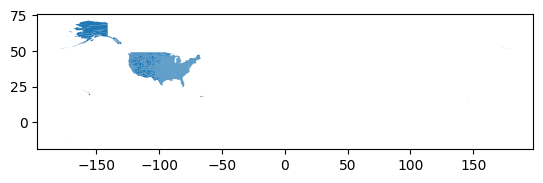

In [13]:
census_counties.plot()

In [61]:
updated_counties2 = census_counties[census_counties['STATEFP']=='17']
updated_counties2


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
11,17,091,00424247,0500000US17091,17091,Kankakee,06,1752121058,12440760,"POLYGON ((-88.25150 41.11422, -88.24089 41.114..."
12,17,187,01785134,0500000US17187,17187,Warren,06,1404747944,1674135,"POLYGON ((-90.78965 40.63685, -90.78956 40.642..."
13,17,197,01785190,0500000US17197,17197,Will,06,2164927644,34548925,"POLYGON ((-88.26127 41.72466, -88.25477 41.724..."
288,17,027,00424215,0500000US17027,17027,Clinton,06,1227664369,75635324,"POLYGON ((-89.70695 38.65503, -89.68784 38.655..."
289,17,031,01784766,0500000US17031,17031,Cook,06,2447370818,1786313044,"POLYGON ((-88.26364 42.06687, -88.25835 42.066..."
...,...,...,...,...,...,...,...,...,...,...
3029,17,143,01784920,0500000US17143,17143,Peoria,06,1602352656,30706564,"POLYGON ((-89.98860 40.62801, -89.98889 40.629..."
3039,17,169,01785037,0500000US17169,17169,Schuyler,06,1132511778,10511618,"POLYGON ((-90.91288 40.14382, -90.91197 40.193..."
3040,17,171,00424286,0500000US17171,17171,Scott,06,649861225,4812707,"POLYGON ((-90.64599 39.70337, -90.64525 39.706..."
3067,17,199,01785215,0500000US17199,17199,Williamson,06,1088263100,62602559,"POLYGON ((-89.15264 37.68680, -89.15238 37.712..."


<Axes: >

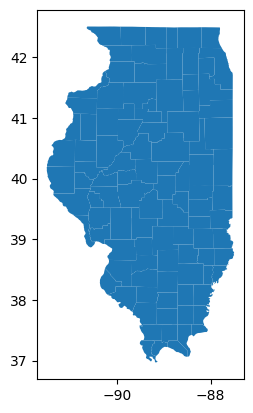

In [15]:
updated_counties2.plot()


KeyError: 'white'

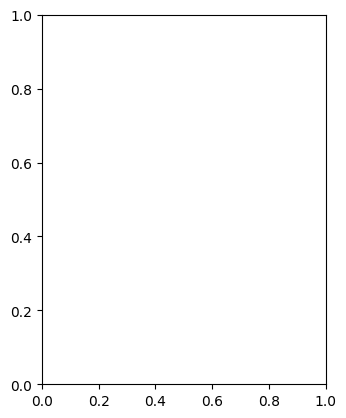

In [16]:
updated_counties2.plot(column="white",legend=True)


AttributeError: Line2D.set() got an unexpected keyword argument 'columns'

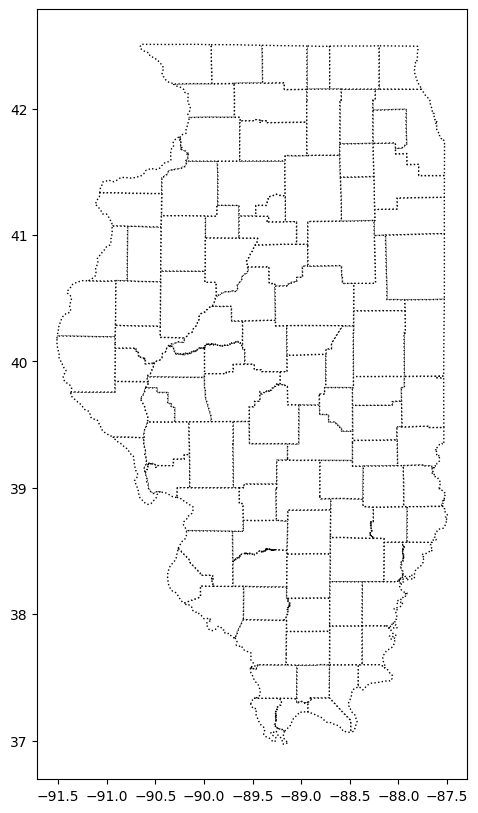

In [17]:
# plotting the isochrones
ax = updated_counties2.plot(figsize=(10, 10), color='white', linestyle=':', edgecolor='black')
census_counties_data.plot(ax=ax, alpha = 0.3, columns='black')

census_counties_data

<Axes: >

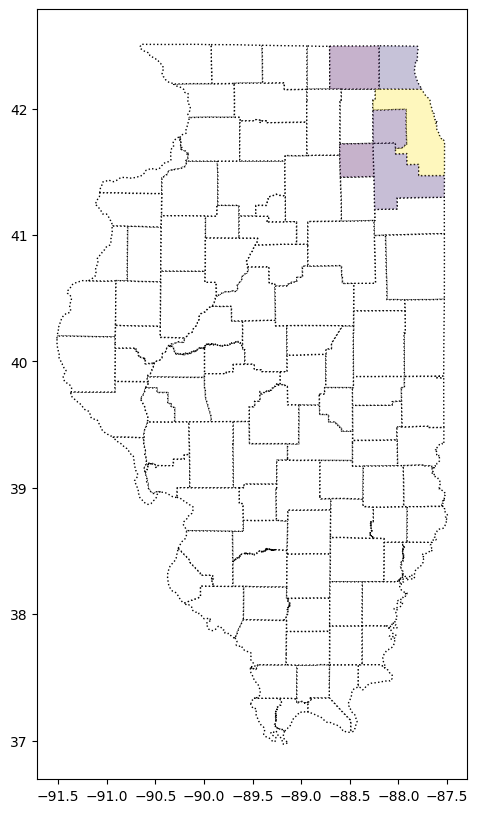

In [56]:
# plotting the isochrones
ax = updated_counties2.plot(figsize=(10, 10), color='white', linestyle=':', edgecolor='black')
merged_data.plot(ax=ax, alpha = 0.3, column='native')



In [23]:
updated_counties2.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
11,17,091,00424247,0500000US17091,17091,Kankakee,06,1752121058,12440760,"POLYGON ((-88.25150 41.11422, -88.24089 41.114..."
12,17,187,01785134,0500000US17187,17187,Warren,06,1404747944,1674135,"POLYGON ((-90.78965 40.63685, -90.78956 40.642..."
13,17,197,01785190,0500000US17197,17197,Will,06,2164927644,34548925,"POLYGON ((-88.26127 41.72466, -88.25477 41.724..."
288,17,027,00424215,0500000US17027,17027,Clinton,06,1227664369,75635324,"POLYGON ((-89.70695 38.65503, -89.68784 38.655..."
289,17,031,01784766,0500000US17031,17031,Cook,06,2447370818,1786313044,"POLYGON ((-88.26364 42.06687, -88.25835 42.066..."


In [30]:
updated_counties2.replace('STATEFP'['17'== 'Illinois'])
#code worked but not in the way that I wanted it to

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
11,17,091,00424247,0500000US17091,17091,Kankakee,06,1752121058,12440760,"POLYGON ((-88.25150 41.11422, -88.24089 41.114..."
12,17,187,01785134,0500000US17187,17187,Warren,06,1404747944,1674135,"POLYGON ((-90.78965 40.63685, -90.78956 40.642..."
13,17,197,01785190,0500000US17197,17197,Will,06,2164927644,34548925,"POLYGON ((-88.26127 41.72466, -88.25477 41.724..."
288,17,027,00424215,0500000US17027,17027,Clinton,06,1227664369,75635324,"POLYGON ((-89.70695 38.65503, -89.68784 38.655..."
289,17,031,01784766,0500000US17031,17031,Cook,06,2447370818,1786313044,"POLYGON ((-88.26364 42.06687, -88.25835 42.066..."
...,...,...,...,...,...,...,...,...,...,...
3029,17,143,01784920,0500000US17143,17143,Peoria,06,1602352656,30706564,"POLYGON ((-89.98860 40.62801, -89.98889 40.629..."
3039,17,169,01785037,0500000US17169,17169,Schuyler,06,1132511778,10511618,"POLYGON ((-90.91288 40.14382, -90.91197 40.193..."
3040,17,171,00424286,0500000US17171,17171,Scott,06,649861225,4812707,"POLYGON ((-90.64599 39.70337, -90.64525 39.706..."
3067,17,199,01785215,0500000US17199,17199,Williamson,06,1088263100,62602559,"POLYGON ((-89.15264 37.68680, -89.15238 37.712..."


In [48]:
# Replace 'df' with the name of your DataFrame
updated_counties2['STATEFP'] = updated_counties2['STATEFP'].replace('17', 'Illinois')


updated_counties2['census_name'] = updated_counties2['NAME'].str.cat(updated_counties2['STATEFP'], sep=' County, ')
updated_counties2













/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,census_name
11,Illinois,091,00424247,0500000US17091,17091,Kankakee,06,1752121058,12440760,"POLYGON ((-88.25150 41.11422, -88.24089 41.114...","Kankakee County, Illinois"
12,Illinois,187,01785134,0500000US17187,17187,Warren,06,1404747944,1674135,"POLYGON ((-90.78965 40.63685, -90.78956 40.642...","Warren County, Illinois"
13,Illinois,197,01785190,0500000US17197,17197,Will,06,2164927644,34548925,"POLYGON ((-88.26127 41.72466, -88.25477 41.724...","Will County, Illinois"
288,Illinois,027,00424215,0500000US17027,17027,Clinton,06,1227664369,75635324,"POLYGON ((-89.70695 38.65503, -89.68784 38.655...","Clinton County, Illinois"
289,Illinois,031,01784766,0500000US17031,17031,Cook,06,2447370818,1786313044,"POLYGON ((-88.26364 42.06687, -88.25835 42.066...","Cook County, Illinois"
...,...,...,...,...,...,...,...,...,...,...,...
3029,Illinois,143,01784920,0500000US17143,17143,Peoria,06,1602352656,30706564,"POLYGON ((-89.98860 40.62801, -89.98889 40.629...","Peoria County, Illinois"
3039,Illinois,169,01785037,0500000US17169,17169,Schuyler,06,1132511778,10511618,"POLYGON ((-90.91288 40.14382, -90.91197 40.193...","Schuyler County, Illinois"
3040,Illinois,171,00424286,0500000US17171,17171,Scott,06,649861225,4812707,"POLYGON ((-90.64599 39.70337, -90.64525 39.706...","Scott County, Illinois"
3067,Illinois,199,01785215,0500000US17199,17199,Williamson,06,1088263100,62602559,"POLYGON ((-89.15264 37.68680, -89.15238 37.712...","Williamson County, Illinois"


In [63]:
counties2 = ['Cook County, Illinois', 'Lake County, Illinois', 'DuPage County, Illinois','Will County, Illinois','McHenry County, Illinois','Kane County,Illinois', 'Kendall County, Illinois']  
combined_census_data = updated_counties2[census_state_data['census_name'].isin(counties)]
combined_census_data



/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1475: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [62]:
combined_census = pd.merge(combined_census_data,2,how = "left", on = ["STATE"])
censusboundaries_hhi.head()

KeyError: 'census_name'

In [46]:
census_counties_data

,Unnamed: 0,geo_id,census_name,total_population,total_male,total_female,under_5_years,median_age,over_18_years,over_65_years,white,black,native,asian,islander,other_race,more_one_race,latino,num_households_dp2,perc_hh_w_children,avg_household_size,avg_family_size,pop_in_households,pop_in_households_child,pop_enrolled,college_graduates,tot_pop_birth_native,tot_pop_birth_foreign,speaks_english_only,speaks_english_less_very_well,unemployment_rate,work_from_home,median_hh_income_d,average_hh_income_d,hh_social_security,hh_foodstamps_snap,per_capita_income_d,perc_fam_bellow_poverty,perc_ppl_bellow_poverty,state,county
611,611,0500000US17031,"Cook County, Illinois",5265398,2570478,2694920,312408,37.3,4113751,774279,2740032,1211240,22867,396831,2068,523543,368817,1346949,2044658.0,28.1,2.53,3.33,5176131.0,1553695.0,1276692.0,1489931.0,4163385.0,1102013.0,3215693.0,673502.0,7.3,287499,72121,104880,535150,290776,41706,9.9,13.5,17,31
617,617,0500000US17043,"DuPage County, Illinois",934094,461851,472243,54019,39.7,721393,146886,677738,45922,2202,114491,375,37323,56043,135909,347385.0,32.5,2.65,3.20,921130.0,292539.0,240067.0,325349.0,751394.0,182700.0,630438.0,77913.0,4.8,67401,100292,133288,92573,21700,50344,4.3,6.1,17,43
642,642,0500000US17093,"Kendall County, Illinois",130757,64996,65761,8289,35.8,93603,13534,99830,10664,334,3848,0,5906,10175,26347,43225.0,44.2,3.02,3.42,130431.0,48686.0,38361.0,29326.0,118635.0,12122.0,100369.0,6443.0,4.3,6835,101816,115448,10122,3579,38343,3.1,4.4,17,93
644,644,0500000US17097,"Lake County, Illinois",714484,358911,355573,39917,38.5,542057,102890,499259,48075,3887,58802,424,53828,50209,159640,252731.0,35.1,2.75,3.28,695686.0,233551.0,191435.0,217451.0,581208.0,133276.0,477010.0,65001.0,5.5,45081,97127,136312,68366,21215,49440,5.2,7.6,17,97
651,651,0500000US17111,"McHenry County, Illinois",310749,155410,155339,16737,40.4,237841,46037,275551,4737,476,8440,5,5427,16113,42981,114446.0,34.8,2.70,3.12,308871.0,99397.0,77823.0,74658.0,283400.0,27349.0,253425.0,13138.0,5.1,17853,93801,115692,33060,7136,43047,4.6,6.3,17,111
694,694,0500000US17197,"Will County, Illinois",696403,347369,349034,39619,38.3,523977,91810,487812,79621,2948,39763,140,43346,42773,126302,237043.0,37.6,2.90,3.39,687576.0,238398.0,184424.0,162906.0,610361.0,86042.0,521895.0,48966.0,5.2,32857,95751,116288,63990,21134,40493,5.0,6.8,17,197


In [55]:
merged_data = pd.merge(updated_counties2,census_counties_data,how = "left", on = ["census_name"])
merged_data

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,census_name,Unnamed: 0,geo_id,total_population,total_male,total_female,under_5_years,median_age,over_18_years,over_65_years,white,black,native,asian,islander,other_race,more_one_race,latino,num_households_dp2,perc_hh_w_children,avg_household_size,avg_family_size,pop_in_households,pop_in_households_child,pop_enrolled,college_graduates,tot_pop_birth_native,tot_pop_birth_foreign,speaks_english_only,speaks_english_less_very_well,unemployment_rate,work_from_home,median_hh_income_d,average_hh_income_d,hh_social_security,hh_foodstamps_snap,per_capita_income_d,perc_fam_bellow_poverty,perc_ppl_bellow_poverty,state,county
0,Illinois,091,00424247,0500000US17091,17091,Kankakee,06,1752121058,12440760,"POLYGON ((-88.25150 41.11422, -88.24089 41.114...","Kankakee County, Illinois",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Illinois,187,01785134,0500000US17187,17187,Warren,06,1404747944,1674135,"POLYGON ((-90.78965 40.63685, -90.78956 40.642...","Warren County, Illinois",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Illinois,197,01785190,0500000US17197,17197,Will,06,2164927644,34548925,"POLYGON ((-88.26127 41.72466, -88.25477 41.724...","Will County, Illinois",694.0,0500000US17197,696403.0,347369.0,349034.0,39619.0,38.3,523977.0,91810.0,487812.0,79621.0,2948.0,39763.0,140.0,43346.0,42773.0,126302.0,237043.0,37.6,2.90,3.39,687576.0,238398.0,184424.0,162906.0,610361.0,86042.0,521895.0,48966.0,5.2,32857.0,95751.0,116288.0,63990.0,21134.0,40493.0,5.0,6.8,17.0,197.0
3,Illinois,027,00424215,0500000US17027,17027,Clinton,06,1227664369,75635324,"POLYGON ((-89.70695 38.65503, -89.68784 38.655...","Clinton County, Illinois",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Illinois,031,01784766,0500000US17031,17031,Cook,06,2447370818,1786313044,"POLYGON ((-88.26364 42.06687, -88.25835 42.066...","Cook County, Illinois",611.0,0500000US17031,5265398.0,2570478.0,2694920.0,312408.0,37.3,4113751.0,774279.0,2740032.0,1211240.0,22867.0,396831.0,2068.0,523543.0,368817.0,1346949.0,2044658.0,28.1,2.53,3.33,5176131.0,1553695.0,1276692.0,1489931.0,4163385.0,1102013.0,3215693.0,673502.0,7.3,287499.0,72121.0,104880.0,535150.0,290776.0,41706.0,9.9,13.5,17.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Illinois,143,01784920,0500000US17143,17143,Peoria,06,1602352656,30706564,"POLYGON ((-89.98860 40.62801, -89.98889 40.629...","Peoria County, Illinois",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,Illinois,169,01785037,0500000US17169,17169,Schuyler,06,1132511778,10511618,"POLYGON ((-90.91288 40.14382, -90.91197 40.193...","Schuyler County, Illinois",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,Illinois,171,00424286,0500000US17171,17171,Scott,06,649861225,4812707,"POLYGON ((-90.64599 39.70337, -90.64525 39.706...","Scott County, Illinois",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,Illinois,199,01785215,0500000US17199,17199,Williamson,06,1088263100,62602559,"POLYGON ((-89.15264 37.68680, -89.15238 37.712...","Williamson County, Illinois",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
counties = ['Cook County, Illinois', 'Lake County, Illinois', 'DuPage County, Illinois','Will County, Illinois','McHenry County, Illinois','Kane County,Illinois', 'Kendall County, Illinois']  # replace with your actual counties
census_counties_data = census_state_data[census_state_data['census_name'].isin(counties)]
census_counties_data

<Axes: >

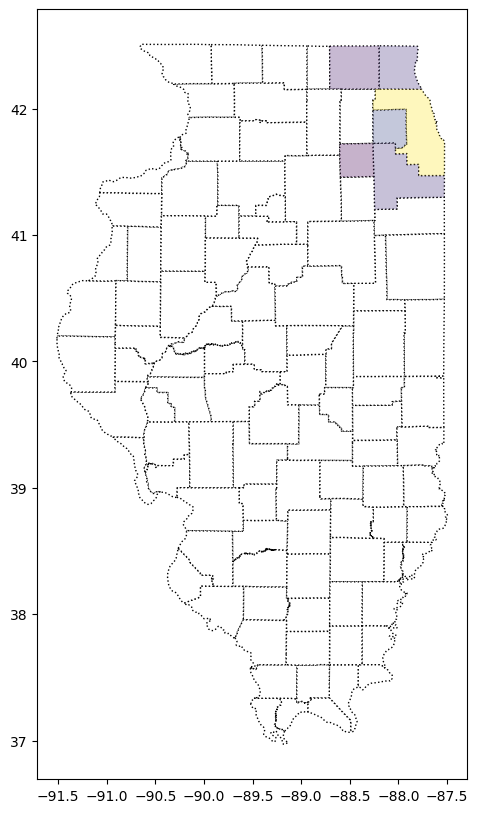

In [58]:
# plotting the isochrones
ax = updated_counties2.plot(figsize=(10, 10), color='white', linestyle=':', edgecolor='black')
merged_data.plot(ax=ax, alpha = 0.3, column='white')
